In [2]:
import csv
import itertools
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
from bs4 import BeautifulSoup
from collections import namedtuple
from glob import glob
import requests
import sys
import nltk
import numpy as np
import warnings
# warnings.filterwarnings("error")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import yfinance as yf
from datetime import datetime , timedelta
from docopt import docopt
from tqdm import tqdm
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
SEC_GOV_URL = 'https://www.sec.gov/Archives'
FORM_INDEX_URL = os.path.join(
    SEC_GOV_URL, 'edgar', 'full-index', '{}', 'QTR{}', 'form.idx')
IndexRecord = namedtuple(
    "IndexRecord", ["form_type", "company_name", "cik", "date_filed", "filename" , "Ticker"])

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def call_sec(url):
    return requests.get(url)

def get(url):
    return call_sec(url).text

In [15]:
data = pd.read_excel('Worksheet in SEC 10K Insights.xlsm')

In [16]:
data = data.set_index('Name')
data.loc['3M Company']['Symbol']
Names = list(data.index)

In [7]:
def download_and_extract_index(year_start ,year_end):
    index_dir = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index'
    if not os.path.exists(index_dir):
        os.makedirs(index_dir)

    for year, qtr in itertools.product(range(year_start, year_end+1), range(1, 5)):

        index_url = "https://www.sec.gov/Archives/edgar/full-index/"+str(year)+"/QTR"+str(qtr)+"/form.idx"
        try:
            print("request index - {}".format(index_url))
            res = requests.get(index_url)
            form_idx = "year{}_qtr{}.index".format(year, qtr)
            form_idx_path = os.path.join(index_dir, form_idx)

            print("writing index to {}".format(form_idx_path))
            with open(form_idx_path, 'w') as fout:
                fout.write(res.text)
        except:
            print("download index failed - {}".format(index_url))

In [73]:
download_and_extract_index(2014,2016)

request index - https://www.sec.gov/Archives/edgar/full-index/2014/QTR1/form.idx
writing index to C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr1.index
request index - https://www.sec.gov/Archives/edgar/full-index/2014/QTR2/form.idx
writing index to C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr2.index
request index - https://www.sec.gov/Archives/edgar/full-index/2014/QTR3/form.idx
writing index to C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr3.index
request index - https://www.sec.gov/Archives/edgar/full-index/2014/QTR4/form.idx
writing index to C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr4.index
request index - https://www.sec.gov/Archives/edgar/full-index/2015/QTR1/form.idx
writing index to C:\Users\vinay\Downloads\ProjectStockPrice

In [7]:
def parse_row_to_record(row, fields_begin):
        record = []
        flag = 0
        for begin, end in zip(fields_begin[:], fields_begin[1:] + [len(row)]):
            field = row[begin:end].rstrip()
            field = field.strip('\"')
            record.append(field)
#         print(record[1])
        if record[1] in Names :
            record.append(data.loc[record[1]]['Symbol'])
            flag = 1
#             print(record)

        return record , flag

index_dir = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index'
records = []
for index_file in sorted(glob(os.path.join(index_dir, "*.index"))):
    print("Extracting 10k records from index {}".format(index_file))

    with open(index_file, 'r') as fin:
        # If arrived at 10-K section of forms
        arrived = False

        for row in fin.readlines():
            if row.startswith("Form Type"):
                fields_begin = [row.find("Form Type"),
                                row.find("Company Name"),
                                row.find('CIK'),
                                row.find('Date Filed'),
                                row.find("File Name")]

            elif row.startswith("10-K "):
                arrived = True
                rec , flag= parse_row_to_record(row, fields_begin)
#                 if rec[1] in Names:
                if flag:
                    records.append(IndexRecord(*rec))

            elif arrived == True:
                break

index_10k_path = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index.csv'
with open(index_10k_path, 'w') as fout:
    writer = csv.writer(fout, delimiter=',',
                        quotechar='\"', quoting=csv.QUOTE_ALL)
    for rec in records:
        writer.writerow(tuple(rec))

Extracting 10k records from index C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr1.index
Extracting 10k records from index C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr2.index
Extracting 10k records from index C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr3.index
Extracting 10k records from index C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2014_qtr4.index
Extracting 10k records from index C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2015_qtr1.index
Extracting 10k records from index C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index\year2015_qtr2.index
Extracting 10k records from index C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform

In [8]:
def download_10k():
    """Downloads 10k HTML and saves only text 
    """
    index_10k_path = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\index.csv'
    assert os.path.exists(index_10k_path)
    form10k_dir = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\form10k'
    if not os.path.exists(form10k_dir):
        os.makedirs(form10k_dir)

    with open(index_10k_path, 'r') as fin:
        reader = csv.reader(
            fin, delimiter=',', quotechar='\"', quoting=csv.QUOTE_ALL)
        count = 0
        for row in reader:
            if count%2 == 0:
                print(row)
                _, company, _, date, filename , ticker= row
                dt = date.split('-')
                url = os.path.join(SEC_GOV_URL, filename).replace("\\", "/")
                print('request 10k html - {}'.format(url))
                try:
                    res = requests.get(url)
                    res = res.content
                    soup = BeautifulSoup(res, "html.parser")
                    text = soup.get_text("\n")
                    fname = ticker+"_"+dt[0]+".txt"
                    text_path = os.path.join(form10k_dir, fname)
                    print("writing 10k text to {}".format(text_path))
                    with open(text_path, "w" , encoding='utf-8') as f:
                        f.write(text)
                except Exception as e:
                    print("download 10k failed - {} - {}".format(url, e))
            count += 1

In [ ]:
download_10k()

['10-K', 'AbbVie Inc.', '1551152', '2014-02-21', 'edgar/data/1551152/0001047469-14-001154.txt', 'ABBV']
request 10k html - https://www.sec.gov/Archives/edgar/data/1551152/0001047469-14-001154.txt
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\form10k\ABBV_2014.txt
['10-K', 'Aon plc', '315293', '2014-02-18', 'edgar/data/315293/0001445305-14-000476.txt', 'AON']
request 10k html - https://www.sec.gov/Archives/edgar/data/315293/0001445305-14-000476.txt
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\form10k\AON_2014.txt
['10-K', 'Avery Dennison Corp', '8818', '2014-02-26', 'edgar/data/8818/0001047469-14-001386.txt', 'AVY']
request 10k html - https://www.sec.gov/Archives/edgar/data/8818/0001047469-14-001386.txt
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\Perform Sentiment Analysis on SEC 10k\form10k\AVY_2014.txt
['10-K', 'Discover Financ

In [10]:
cik_ticker = { 'AMZN': '0001018724', 'BMY': '0000014272', 'CNP': '0001130310','CVX': '0000093410','FL': '0000850209'}
tick = list(cik_ticker.keys())

In [17]:
def get_sec_data(cik, doc_type, start=0, count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]

    return entries

sec_data = {}
start_year = 2014
end_year = 2018
for ticker, cik in cik_ticker.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

In [20]:
from datetime import datetime
    
raw_fillings_by_ticker = {}
def write_raw_data():
    index_path = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data'
    for ticker, data in sec_data.items():
        raw_fillings_by_ticker[ticker] = {}
        for index_url, file_type, file_date in data:
            dater = datetime.strptime(file_date, '%Y-%m-%d')
            if (file_type == '10-K') and (dater.year >= start_year and dater.year <= end_year):
    #             print(dater.year)
                file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
                try:
                    raw_fillings_by_ticker[ticker][file_date] = get(file_url)
                    soup = BeautifulSoup(raw_fillings_by_ticker[ticker][file_date], "html.parser")
                    text = soup.get_text("\n")
                    fname = ticker+"_"+str(dater.year)
                    text_path = os.path.join(index_path, fname)
                    print("writing 10k text to {}".format(text_path))
                    with open(text_path, 'w' , encoding='utf8') as fout:
                        fout.write(text)
                except:
                    pass

write_raw_data()

writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2018
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2017
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2016
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2015
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2014
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\BMY_2018
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\BMY_2017
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\BMY_2016
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_D

C:\Users\vinay\Anaconda3\lib\site-packages\bs4\builder\_htmlparser.py:78: UserWarning: unknown status keyword 'S' in marked section
  warnings.warn(msg)


writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2018


C:\Users\vinay\Anaconda3\lib\site-packages\bs4\builder\_htmlparser.py:78: UserWarning: expected name token at "<![$% /,MCH\nM@3H'&&S"
  warnings.warn(msg)


writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2016
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2015
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2014
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2018
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2017
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2016
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2015
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2014
writing 10k text to C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\F

In [21]:
def normalize_text(text):
    """Nomralize Text
    """
    text = unicodedata.normalize("NFKD", text)  # Normalize
    text = '\n'.join(
        text.splitlines())  # Let python take care of unicode break lines

    # Convert to upper
    text = text.upper()  # Convert to upper

    # Take care of breaklines & whitespaces combinations due to beautifulsoup parsing
    text = re.sub(r'[ ]+\n', '\n', text)
    text = re.sub(r'\n[ ]+', '\n', text)
    text = re.sub(r'\n+', '\n', text)

    # To find section, reformat item headers
    text = text.replace('\n.\n', '.\n')  # Move Period to beginning

    text = text.replace('\nI\nTEM', '\nITEM')
    text = text.replace('\nITEM\n', '\nITEM ')
    text = text.replace('\nITEM  ', '\nITEM ')

    text = text.replace(':\n', '.\n')

    # Math symbols for clearer looks
    text = text.replace('$\n', '$')
    text = text.replace('\n%', '%')

    # Reformat
    text = text.replace('\n', '\n\n')  # Reformat by additional breakline

    return text

In [22]:
def parse_qq(text, start=0):
    debug = False
    """Parse normalized text 
    """

    qq = ""
    end = 0
    """
        Parsing Rules
    """

    # Define start & end signal for parsing
    item7A_begins = [
        '\nITEM 7A.', '\nITEM 7A –', '\nITEM 7A:', '\nITEM 7A ', '\nITEM 7A\n'
    ]
    item7A_ends = ['\nITEM 8']
    if start != 0:
        item7A_ends.append('\nITEM 7A')  # Case: ITEM 7A does not exist
    item9_begins = ['\nITEM 9']
    """
        Parsing code section
    """
    text = text[start:]

    # Get begin
    for item7A in item7A_begins:
        begin = text.find(item7A)
        if debug:
            print(item7A, begin)
        if begin != -1:
            break

    if begin != -1:  # Begin found
        for item8 in item7A_ends:
            end = text.find(item8, begin + 1)
            if debug:
                print(item8, end)
            if end != -1:
                break

        if end == -1:  # ITEM 7A does not exist
            for item9 in item9_begins:
                end = text.find(item9, begin + 1)
                if debug:
                    print(item9, end)
                if end != -1:
                    break

        # Get MDA
        if end > begin:
            qq = text[begin:end].strip()
        else:
            end = 0

    return qq, end

In [23]:
def parse_mda(text, start=0):
    debug = False
    """Parse normalized text 
    """

    mda = ""
    end = 0
    """
        Parsing Rules
    """

    # Define start & end signal for parsing
    item7_begins = [
        '\nITEM 7.', '\nITEM 7 –', '\nITEM 7:', '\nITEM 7 ', '\nITEM 7\n'
    ]
    item7_ends = ['\nITEM 7A']
    if start != 0:
        item7_ends.append('\nITEM 7')  # Case: ITEM 7A does not exist
    item8_begins = ['\nITEM 8']
    """
        Parsing code section
    """
    text = text[start:]

    # Get begin
    for item7 in item7_begins:
        begin = text.find(item7)
        if debug:
            print(item7, begin)
        if begin != -1:
            break

    if begin != -1:  # Begin found
        for item7A in item7_ends:
            end = text.find(item7A, begin + 1)
            if debug:
                print(item7A, end)
            if end != -1:
                break

        if end == -1:  # ITEM 7A does not exist
            for item8 in item8_begins:
                end = text.find(item8, begin + 1)
                if debug:
                    print(item8, end)
                if end != -1:
                    break

        # Get MDA
        if end > begin:
            mda = text[begin:end].strip()
        else:
            end = 0

    return mda, end

In [24]:
def parse_rf(text, start=0):
    debug = False
    """Parse normalized text 
    """

    rf = ""
    end = 0
    """
        Parsing Rules
    """

    # Define start & end signal for parsing
    item1A_begins = [
        '\nITEM 1A.', '\nITEM 1A –', '\nITEM 1A:', '\nITEM 1A ', '\nITEM 1A\n'
    ]
    item1A_ends = ['\nITEM 1B']
    if start != 0:
        item1A_ends.append('\nITEM 1A')  # Case: ITEM 1B does not exist
    item2_begins = ['\nITEM 2']
    """
        Parsing code section
    """
    text = text[start:]

    # Get begin
    for item1A in item1A_begins:
        begin = text.find(item1A)
        if debug:
            print(item1A, begin)
        if begin != -1:
            break

    if begin != -1:  # Begin found
        for item1B in item1A_ends:
            end = text.find(item1B, begin + 1)
            if debug:
                print(item1B, end)
            if end != -1:
                break

        if end == -1:  # ITEM 1B does not exist
            for item2 in item2_begins:
                end = text.find(item2, begin + 1)
                if debug:
                    print(item2, end)
                if end != -1:
                    break

        # Get MDA
        if end > begin:
            rf = text[begin:end].strip()
        else:
            end = 0

    return rf, end

In [25]:
from os import listdir
from os.path import isfile, join

def extract_context(form10k_dir , clean_text):
    assert os.path.exists(form10k_dir)
    if not os.path.exists(clean_text):
        os.makedirs(clean_text)
    onlyfiles = [os.path.join(form10k_dir,f) for f in listdir(form10k_dir) if isfile(join(form10k_dir, f))]
    for form10k_file in tqdm(onlyfiles):
        print("extracting content from form10k file {}".format(form10k_file))
        with open(form10k_file, 'r' , encoding='utf8') as fin:
            text = fin.read()

            text = normalize_text(text)

            mda, end = parse_mda(text)

            if mda and len(mda.encode('utf-8')) < 1000:
                mda, _ = parse_mda(text, start=end)

            rf, end = parse_rf(text)
            if rf and len(rf.encode('utf-8')) < 1000:
                rf, _ = parse_rf(text, start=end)

            qq , end = parse_qq(text)
            if qq and len(qq.encode('utf-8')) < 1000:
                qq , _ = parse_qq(text, start=end)

            data = mda + " \n " + rf + " \n " + qq

        try:
            filename = os.path.basename(form10k_file)
            name = ""
            name, ext = os.path.splitext(filename)
            print(name ,"    ", ext)
            clean_text2 = ""
            clean_text2 = os.path.join(clean_text, name + ".txt")
            with open(clean_text2, 'w' , encoding='utf8') as fout:
                if mda:
                    fout.write(mda)
                if rf:
                    fout.write(rf)
                if qq:
                    fout.write(qq)
        except Exception as e:
            print("extract mda failed - {}".format(form10k_file),e)

In [26]:
form10k_dir = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data'
clean_text = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Cleaned_data'
extract_context(form10k_dir , clean_text)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2014
AMZN_2014      


  4%|███▌                                                                               | 1/23 [00:01<00:34,  1.56s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2015
AMZN_2015      


  9%|███████▏                                                                           | 2/23 [00:03<00:34,  1.64s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2016
AMZN_2016      


 13%|██████████▊                                                                        | 3/23 [00:03<00:25,  1.29s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2017
AMZN_2017      


 17%|██████████████▍                                                                    | 4/23 [00:04<00:19,  1.03s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\AMZN_2018
AMZN_2018      


 22%|██████████████████                                                                 | 5/23 [00:04<00:15,  1.17it/s]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\BMY_2015
BMY_2015      


 26%|█████████████████████▋                                                             | 6/23 [00:08<00:29,  1.74s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\BMY_2016
BMY_2016      


 30%|█████████████████████████▎                                                         | 7/23 [00:10<00:27,  1.71s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\BMY_2017
BMY_2017      


 35%|████████████████████████████▊                                                      | 8/23 [00:11<00:25,  1.71s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\BMY_2018
BMY_2018      


 39%|████████████████████████████████▍                                                  | 9/23 [00:13<00:23,  1.70s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2014
CNP_2014      


 43%|███████████████████████████████████▋                                              | 10/23 [00:16<00:26,  2.01s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2015
CNP_2015      


 48%|███████████████████████████████████████▏                                          | 11/23 [00:19<00:28,  2.40s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2016
CNP_2016      


 52%|██████████████████████████████████████████▊                                       | 12/23 [00:20<00:20,  1.91s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CNP_2018
CNP_2018      


 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:21<00:17,  1.72s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2014
CVX_2014      


 61%|█████████████████████████████████████████████████▉                                | 14/23 [00:27<00:25,  2.86s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2015
CVX_2015      


 65%|█████████████████████████████████████████████████████▍                            | 15/23 [00:30<00:24,  3.00s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2016
CVX_2016      


 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:32<00:18,  2.59s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2017
CVX_2017      


 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:33<00:14,  2.36s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\CVX_2018
CVX_2018      


 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [00:35<00:10,  2.15s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\FL_2014
FL_2014      


 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [00:37<00:08,  2.09s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\FL_2015
FL_2015      


 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:39<00:06,  2.18s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\FL_2016
FL_2016      


 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [00:41<00:03,  1.92s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\FL_2017
FL_2017      


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [00:43<00:01,  1.87s/it]

extracting content from form10k file C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Un_Cleaned_Data\FL_2018
FL_2018      


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:44<00:00,  1.86s/it]


In [27]:
ten_ks_by_ticker = {}

for ticker, filling_documents in raw_fillings_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        ten_ks_by_ticker[ticker].append({
            'cik': cik_ticker[ticker],
            'file_date': file_date})

In [28]:
clean_text = r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Cleaned_data'
onlyfiles = [os.path.join(clean_text,f) for f in listdir(clean_text) if isfile(join(clean_text, f))]
def clean_text(ticker , file_date):
    text = ""
    for onlyfile in onlyfiles:
        filename = os.path.basename(onlyfile)
        tick , year = filename.split("_")
        year , _ = year.split(".")
        dater = datetime.strptime(file_date, '%Y-%m-%d')
        if str(tick.strip()) == str(ticker)  and str(year) == str(dater.year):
            with open(onlyfile, 'r' , encoding='utf8') as fin:
                text = fin.read()
#                 print(text[:50])
            break               
    if text:
        return text
    else:
        text = " "
        return text

index_path_clean = r"C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\Cleaned_data"
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        ten_k['file_clean'] = clean_text(ticker , ten_k['file_date'])

In [29]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_words(words):
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    
    return lemmatized_words

In [30]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

In [31]:
lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

def remove_stop_words(ten_ks_by_ticker , lemma_english_stopwords):
    for ticker, ten_ks in ten_ks_by_ticker.items():
        for ten_k in ten_ks:
            ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]
            
    return ten_ks_by_ticker

ten_ks_by_ticker = remove_stop_words(ten_ks_by_ticker , lemma_english_stopwords)

print('Stop Words Removed')

Stop Words Removed


In [32]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious']
sentiment_df = pd.read_csv(r'C:\Users\vinay\Downloads\ProjectStockPricePrediction\sec10insights\LoughranMcDonald_MasterDictionary_2018.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

negative  positive  uncertainty  litigious          word
9       True     False        False      False       abandon
12      True     False        False      False   abandonment
13      True     False        False      False  abandonments
51      True     False        False      False      abdicate
54      True     False        False      False    abdication

In [33]:
set_frame = {'date': [], 'ticker': [], 'negative': [], 'positive': [], 'uncertainty' : [], 'litigious': [] , 'market_return' : []}
sentiments = ['negative', 'positive', 'uncertainty', 'litigious']

In [34]:
import math
set_frame_log = {'date': [], 'ticker': [], 'negative': [], 'positive': [], 'uncertainty' : [], 'litigious': [] , 'market_sentiment' : []}

In [35]:
def get_bag_of_words(sentiment_words, docs):
    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]

    return bag_of_words.astype(int)

In [36]:
sentiment_bow_ten_ks = {}
for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [37]:
# sentiment_bow_ten_ks

In [38]:
def get_tfidf(sentiment_words, docs):
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [40]:
sentiment_tfidf_ten_ks

{'AMZN': {'negative': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'positive': array([[0.55029663, 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.52652925, 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.51221349, 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.50837483, 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.51286985, 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  'uncertainty': array([[0.        , 0.        , 0.        , ..., 0.01387731, 0.00693866,
          0.01387731],
         [0.        , 0.        , 0.        , ..., 0.01467126, 0.00733563,
          0.01467126],
         [0.        , 0.        , 0.        , ..., 0.01426339, 

In [42]:
def calculate_market_sentiments(date_time , ticker):
    current_date = datetime.strptime(date_time,'%Y-%m-%d')
    start_date = current_date - timedelta(days = 5)
    end_date = current_date + timedelta(days = 5)
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data.drop('Volume', axis=1)
    data = data.drop('High', axis=1)
    data = data.drop('Low', axis=1)
    data = data.drop('Open', axis=1)
    data = data.drop('Close', axis=1)
    start = data["Adj Close"].iloc[0]
    end = data["Adj Close"].iloc[len(data["Adj Close"])-1]
    market_sentiment = ((end - start)/start)
    
    return market_sentiment

In [41]:
set_frames = {'date': [], 'ticker': [], 'negative': [], 'positive': [], 'uncertainty' : [], 'litigious': [] , 'market_return' : []}
sentiments = ['negative', 'positive', 'uncertainty', 'litigious']

In [43]:
for ticker , ten_ks in ten_ks_by_ticker.items():
    count = 0
    for ten_k in ten_ks:
        set_frames['ticker'].append(ticker)
        set_frames['date'].append(ten_k['file_date'])
        set_frames['negative'].append(np.sum(sentiment_tfidf_ten_ks[ticker]['negative'][count]))
        set_frames['positive'].append(np.sum(sentiment_tfidf_ten_ks[ticker]['positive'][count]))
        set_frames['uncertainty'].append(np.sum(sentiment_tfidf_ten_ks[ticker]['uncertainty'][count]))
        set_frames['litigious'].append(np.sum(sentiment_tfidf_ten_ks[ticker]['litigious'][count]))
        market_sentiment = calculate_market_sentiments(ten_k['file_date'] , ticker)
        set_frames['market_return'].append(market_sentiment)
        count += 1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [44]:
set_frames = pd.DataFrame(set_frames)
set_frames.to_csv("Market_Sentiments.csv")

In [45]:
set_frames = pd.DataFrame(set_frames)
set_frames

date ticker  negative  positive  uncertainty  litigious  \
0   2018-02-02   AMZN  5.284034  4.732551     2.272840   3.510357   
1   2017-02-10   AMZN  5.332749  4.646257     2.253376   2.972743   
2   2016-01-29   AMZN  5.586672  4.656521     2.290575   3.055778   
3   2015-01-30   AMZN  5.616080  4.655515     2.331875   3.069077   
4   2014-01-31   AMZN  5.640202  4.553680     2.350885   3.372184   
5   2018-02-13    BMY  6.686287  4.985176     2.794253   3.855538   
6   2017-02-21    BMY  6.566823  4.431564     2.862656   3.639128   
7   2016-02-12    BMY  6.332925  4.600085     3.095691   3.806061   
8   2015-02-13    BMY  5.918668  3.791128     3.142485   3.344603   
9   2014-02-14    BMY  0.000000  0.000000     0.000000   0.000000   
10  2018-02-22    CNP  5.538563  1.526793     2.228482   3.259768   
11  2017-02-28    CNP  0.000000  0.000000     0.000000   0.000000   
12  2016-02-26    CNP  5.686862  1.558035     2.311897   3.769690   
13  2015-02-26    CNP  5.467768  1.557027     2.293547   3.999249   
14  2014-02-26    CNP  5.489727  1.463965     2.288927   3.875303   
15  2018-02-22    CVX  6.365496  3.522643     2.498057   2.982313   
16  2017-02-23    CVX  6.331430  3.293147     2.550675   3.186964   
17  2016-02-25    CVX  5.538876  3.157389     2.494280   2.631174   
18  2015-02-20    CVX  5.155806  3.339404     2.630027   2.826795   
19  2014-02-21    CVX  5.195928  3.186584     2.636321   2.857600   
20  2018-03-29     FL  5.306094  5.207964     2.919362   4.041026   
21  2017-03-23     FL  5.360178  4.872831     3.175390   3.781628   
22  2016-03-24     FL  5.331096  4.677601     3.126749   3.904546   
23  2015-03-30     FL  5.310430  4.414884     2.898973   4.193534   
24  2014-03-31     FL  5.290790  4.538781     2.908776   4.240683   

    market_return  
0        0.017747  
1        0.035598  
2       -0.074481  
3        0.174030  
4       -0.099229  
5        0.101070  
6        0.025622  
7        0.024045  
8        0.021240  
9        0.048158  
10       0.032702  
11       0.050056  
12       0.001610  
13      -0.047860  
14      -0.025948  
15       0.021937  
16       0.012870  
17      -0.035376  
18      -0.039502  
19       0.020052  
20       0.001829  
21      -0.037928  
22      -0.000307  
23      -0.001277  
24       0.005427

In [46]:
def probability_distribution(df):

    df['normalized_sentiment'] = ((df['positive'] - df['negative'])/(df['positive'] +df['negative']+
                                                         df['uncertainty'] + df['litigious']+4))
    return df
df = set_frames
df4 = probability_distribution(df)
df4

date ticker  negative  positive  uncertainty  litigious  \
0   2018-02-02   AMZN  5.284034  4.732551     2.272840   3.510357   
1   2017-02-10   AMZN  5.332749  4.646257     2.253376   2.972743   
2   2016-01-29   AMZN  5.586672  4.656521     2.290575   3.055778   
3   2015-01-30   AMZN  5.616080  4.655515     2.331875   3.069077   
4   2014-01-31   AMZN  5.640202  4.553680     2.350885   3.372184   
5   2018-02-13    BMY  6.686287  4.985176     2.794253   3.855538   
6   2017-02-21    BMY  6.566823  4.431564     2.862656   3.639128   
7   2016-02-12    BMY  6.332925  4.600085     3.095691   3.806061   
8   2015-02-13    BMY  5.918668  3.791128     3.142485   3.344603   
9   2014-02-14    BMY  0.000000  0.000000     0.000000   0.000000   
10  2018-02-22    CNP  5.538563  1.526793     2.228482   3.259768   
11  2017-02-28    CNP  0.000000  0.000000     0.000000   0.000000   
12  2016-02-26    CNP  5.686862  1.558035     2.311897   3.769690   
13  2015-02-26    CNP  5.467768  1.557027     2.293547   3.999249   
14  2014-02-26    CNP  5.489727  1.463965     2.288927   3.875303   
15  2018-02-22    CVX  6.365496  3.522643     2.498057   2.982313   
16  2017-02-23    CVX  6.331430  3.293147     2.550675   3.186964   
17  2016-02-25    CVX  5.538876  3.157389     2.494280   2.631174   
18  2015-02-20    CVX  5.155806  3.339404     2.630027   2.826795   
19  2014-02-21    CVX  5.195928  3.186584     2.636321   2.857600   
20  2018-03-29     FL  5.306094  5.207964     2.919362   4.041026   
21  2017-03-23     FL  5.360178  4.872831     3.175390   3.781628   
22  2016-03-24     FL  5.331096  4.677601     3.126749   3.904546   
23  2015-03-30     FL  5.310430  4.414884     2.898973   4.193534   
24  2014-03-31     FL  5.290790  4.538781     2.908776   4.240683   

    market_return  normalized_sentiment  
0        0.017747             -0.027853  
1        0.035598             -0.035745  
2       -0.074481             -0.047482  
3        0.174030             -0.048828  
4       -0.099229             -0.054553  
5        0.101070             -0.076210  
6        0.025622             -0.099314  
7        0.024045             -0.079362  
8        0.021240             -0.105340  
9        0.048158              0.000000  
10       0.032702             -0.242350  
11       0.050056              0.000000  
12       0.001610             -0.238296  
13      -0.047860             -0.225825  
14      -0.025948             -0.235178  
15       0.021937             -0.146777  
16       0.012870             -0.156918  
17      -0.035376             -0.133628  
18      -0.039502             -0.101181  
19       0.020052             -0.112402  
20       0.001829             -0.004570  
21      -0.037928             -0.022999  
22      -0.000307             -0.031060  
23      -0.001277             -0.043018  
24       0.005427             -0.035846

In [67]:
set_frame_final = {'date': [], 'ticker': [], 'negative': [], 'positive': [], 'uncertainty' : [], 'litigious': [] , 'market_return' : [] , 'normalized_sentiment' : []}
set_frame_final = {}
for i in tick:
    set_frame_final[i] = {'normalized_market_return':[] , 'normalized_sentiment':[]}

In [68]:
def normalized_market_return(data_frm):

    gk = df.groupby('ticker')
    for i in tick:
        data = gk.get_group(i)
        set_frame_final[i]['normalized_market_return'].append(data['market_return'])
        set_frame_final[i]['normalized_sentiment'].append(data['normalized_sentiment'])
        
normalized_market_return(df4)
set_frame_finals = pd.DataFrame(set_frame_final)
set_frame_finals

AMZN  \
normalized_market_return  [[0.017747242788325963, 0.035597542814312835, ...   
normalized_sentiment      [[-0.02785298923449687, -0.03574522915060918, ...   

                                                                        BMY  \
normalized_market_return  [[0.10107004143547078, 0.02562244431597713, 0....   
normalized_sentiment      [[-0.07621038482530416, -0.0993135562261739, -...   

                                                                        CNP  \
normalized_market_return  [[0.032701587878110706, 0.05005643230542792, 0...   
normalized_sentiment      [[-0.24235023082499121, 0.0, -0.23829570370460...   

                                                                        CVX  \
normalized_market_return  [[0.021936789296027437, 0.012870235852596456, ...   
normalized_sentiment      [[-0.146777065122278, -0.1569181683027724, -0....   

                                                                         FL  
normalized_market_return  [[0.0018289292246175801, -0.037927647192041086...  
normalized_sentiment      [[-0.004569652272579125, -0.02299889630757267,...

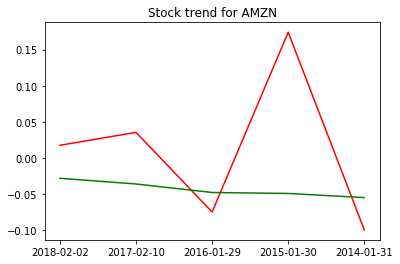

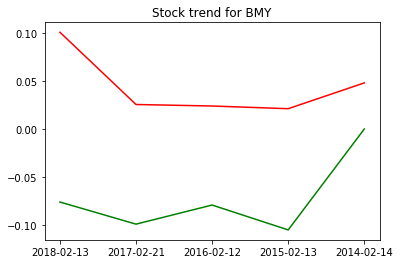

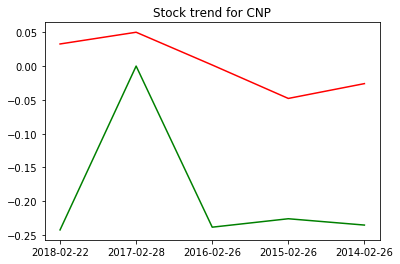

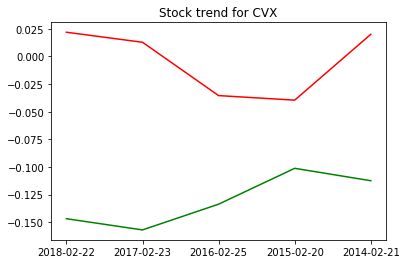

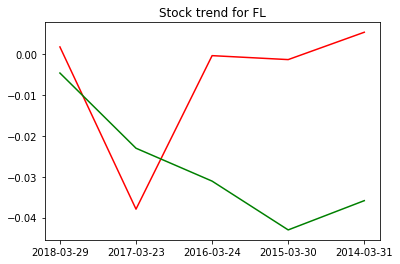

In [75]:
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  
import matplotlib.pyplot as plt
for i in tick: 
    plt.plot(file_dates[i] , np.array(set_frame_final[i]['normalized_market_return']).reshape(-1) , 'r')
    plt.plot(file_dates[i] , np.array(set_frame_final[i]['normalized_sentiment']).reshape(-1) , 'g')
    plt.title('Stock trend for {}'.format(i))
    plt.show()

In [43]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(set_frame, test_size=0.3)
train = train.drop('date', axis=1)
test = test.drop('date',axis=1)
train = train.drop('ticker', axis=1)
test = test.drop('ticker',axis=1)
X = train.loc[:, train.columns!="market_sentiment"]
y = train.iloc[:,-1]

test_X = test.loc[:, test.columns!="market_sentiment"]
test_y = test.iloc[:,-1]

In [44]:
X.head(5)

negative  positive  uncertainty  litigious
8        391       222          325        162
19        53        12           52         27
22       325       155          307        106
5        415       204          318        176
3        335       137          323        152

In [37]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
clf_entropy = DecisionTreeClassifier( random_state=0, max_depth = 2)

In [45]:
clf_entropy.fit(X,y)
test["predict"] = clf_entropy.predict(test_X)
test.head(5)

negative  positive  uncertainty  litigious  market_sentiment  predict
12       751       659          724        333                 1        0
11         0         0            0          0                 1        1
13       634       615          682        315                 1        0
21       350       160          332        124                 1        1
18        57        13           56         28                 0        1

Confusion matrix
[[0 1]
 [3 4]]


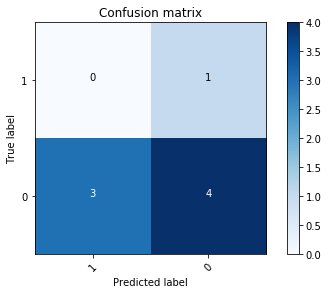

0.5
[[0 1]
 [3 4]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.57      0.67         7

   micro avg       0.50      0.50      0.50         8
   macro avg       0.40      0.29      0.33         8
weighted avg       0.70      0.50      0.58         8



In [46]:
cnf_matrix = confusion_matrix(test["market_sentiment"], test["predict"])
np.set_printoptions(precision=2)
class_names = ['1','0']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

print(accuracy_score(test["market_sentiment"], test["predict"]))
print(confusion_matrix(test["market_sentiment"], test["predict"]))
print(classification_report(test["market_sentiment"], test["predict"]))

In [47]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,10), random_state=1)

clf.fit(X_train,y_train)
test["predict"] = clf.predict(X_test)

print(accuracy_score(test["market_sentiment"], test["predict"]))
print(confusion_matrix(test["market_sentiment"], test["predict"]))
print(classification_report(test["market_sentiment"], test["predict"]))

0.75
[[0 1]
 [1 6]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.86      0.86         7

   micro avg       0.75      0.75      0.75         8
   macro avg       0.43      0.43      0.43         8
weighted avg       0.75      0.75      0.75         8



In [48]:
# Naive Bayes Algo
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
test["predict"] = clf.predict(X_test)

print(accuracy_score(test["market_sentiment"], test["predict"]))
print(confusion_matrix(test["market_sentiment"], test["predict"]))
print(classification_report(test["market_sentiment"], test["predict"]))

0.75
[[0 1]
 [1 6]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.86      0.86         7

   micro avg       0.75      0.75      0.75         8
   macro avg       0.43      0.43      0.43         8
weighted avg       0.75      0.75      0.75         8



In [41]:
def get_jaccard_similarity(bag_of_words_matrix):
    jaccard_similarities = []
    bag_of_words_matrix = np.array(bag_of_words_matrix, dtype=bool)
    for i in range(len(bag_of_words_matrix)-1):
            u = bag_of_words_matrix[i]
            v = bag_of_words_matrix[i+1]
            jaccard_similarities.append(jaccard_similarity_score(u,v))
            
    return jaccard_similarities

In [96]:
def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()

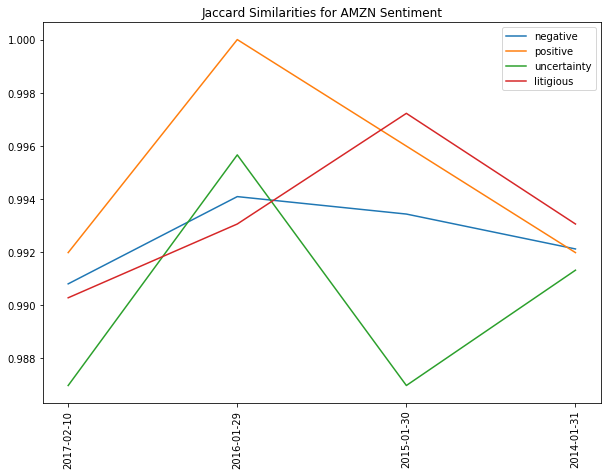

In [50]:
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}

# for ticker in tick:
plot_similarities(
[jaccard_similarities[tick[0]][sentiment] for sentiment in sentiments],
file_dates[example_ticker][1:],
'Jaccard Similarities for {} Sentiment'.format(tick[0]),
sentiments)

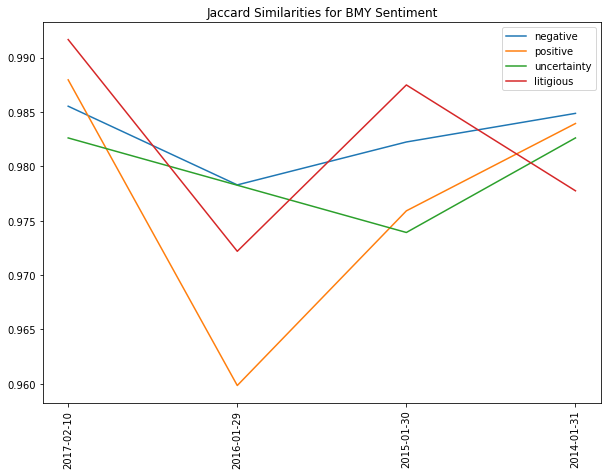

In [49]:
plot_similarities(
[jaccard_similarities[tick[1]][sentiment] for sentiment in sentiments],
file_dates[example_ticker][1:],
'Jaccard Similarities for {} Sentiment'.format(tick[1]),
sentiments)

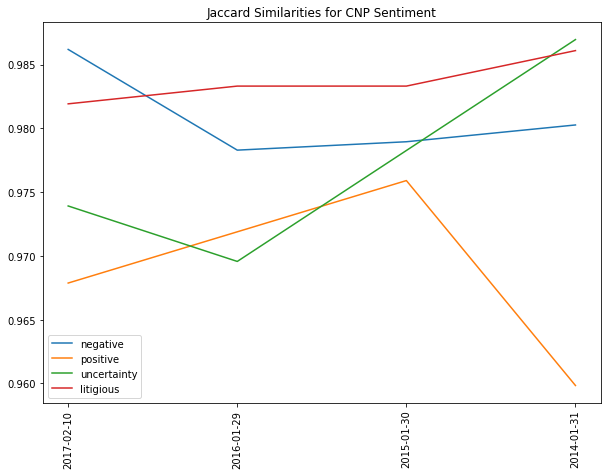

In [51]:
plot_similarities(
[jaccard_similarities[tick[2]][sentiment] for sentiment in sentiments],
file_dates[example_ticker][1:],
'Jaccard Similarities for {} Sentiment'.format(tick[2]),
sentiments)

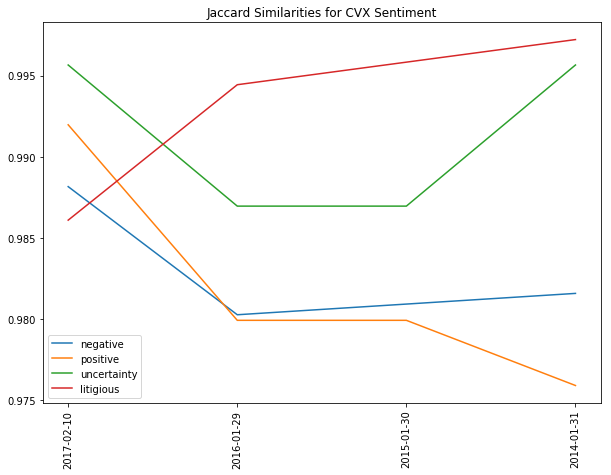

In [52]:
plot_similarities(
[jaccard_similarities[tick[3]][sentiment] for sentiment in sentiments],
file_dates[example_ticker][1:],
'Jaccard Similarities for {} Sentiment'.format(tick[3]),
sentiments)

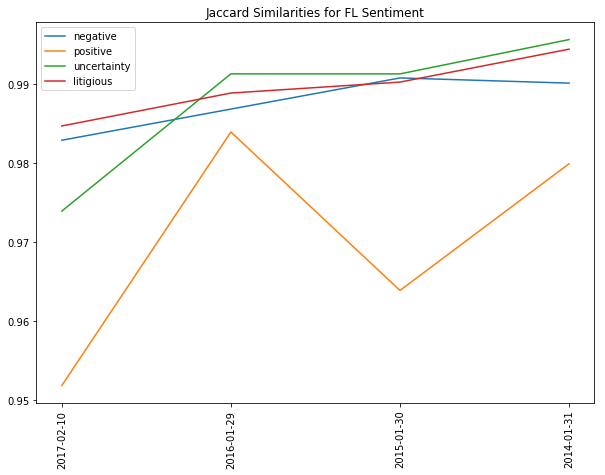

In [53]:
plot_similarities(
[jaccard_similarities[tick[4]][sentiment] for sentiment in sentiments],
file_dates[example_ticker][1:],
'Jaccard Similarities for {} Sentiment'.format(tick[4]),
sentiments)

In [54]:
def get_tfidf(sentiment_words, docs):
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [57]:
def get_cosine_similarity(tfidf_matrix):
    cosine_similarities = []    
    for i in range(len(tfidf_matrix)-1):
        cosine_similarities.append(cosine_similarity(tfidf_matrix[i].reshape(1, -1),tfidf_matrix[i+1].reshape(1, -1))[0,0])
    
    return cosine_similarities

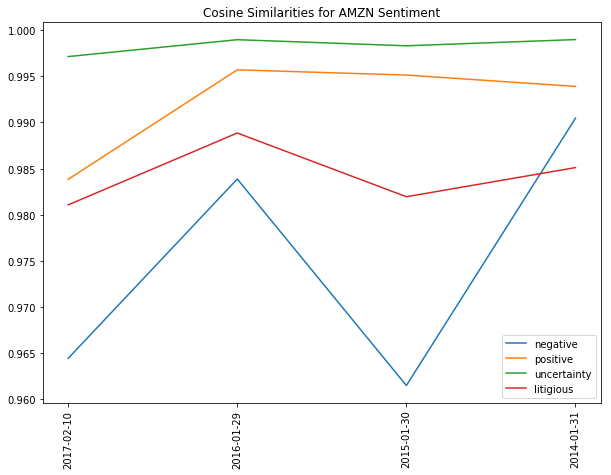

In [58]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


plot_similarities(
    [cosine_similarities[tick[0]][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(tick[0]),
    sentiments)

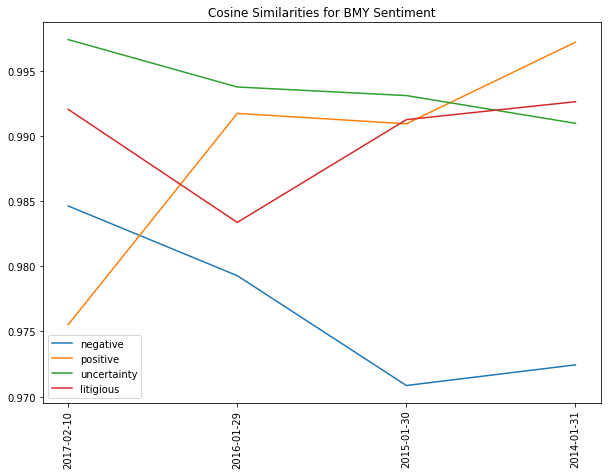

In [59]:
plot_similarities(
    [cosine_similarities[tick[1]][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(tick[1]),
    sentiments)

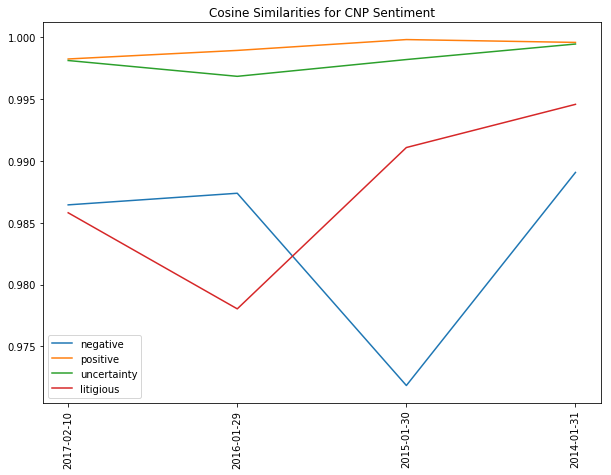

In [60]:
plot_similarities(
    [cosine_similarities[tick[2]][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(tick[2]),
    sentiments)

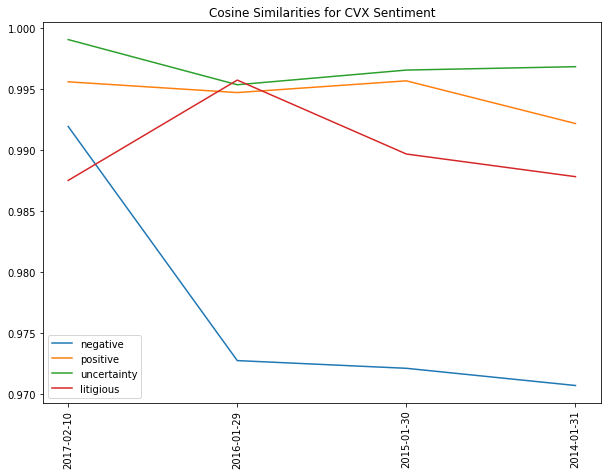

In [61]:
plot_similarities(
    [cosine_similarities[tick[3]][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(tick[3]),
    sentiments)

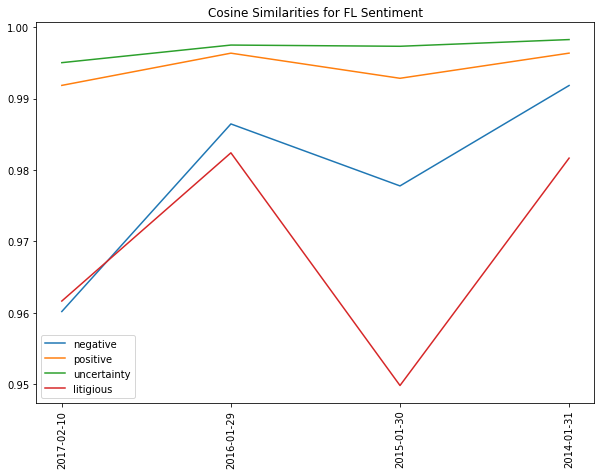

In [62]:
plot_similarities(
    [cosine_similarities[tick[4]][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(tick[4]),
    sentiments)